<a href="https://www.kaggle.com/code/jfjerin/custom-cnn?scriptVersionId=282631666" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/106_cyt01.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/094_cyt02.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/001_cyt08.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/019_nuc09.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/045_nuc02.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/096_nuc08.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/042_nuc01.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/034_nuc05.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/041_nuc05.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/096_nuc07.dat
/kaggle/input/cervical-cancer-largest-dataset-sipa

In [2]:
!pip install torchinfo

# **Import Libraries**

In [3]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

# **Configuration**

In [4]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla T4


# **Seed Value**

In [5]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# **Loading Dataset**

Total images found: 966
Unique Labels: ['Dyskeratotic' 'Metaplastic' 'Koilocytotic' 'Parabasal'
 'Superficial-Intermediate']
Class Distribution:
label
Metaplastic                 271
Koilocytotic                238
Dyskeratotic                223
Superficial-Intermediate    126
Parabasal                   108
Name: count, dtype: int64


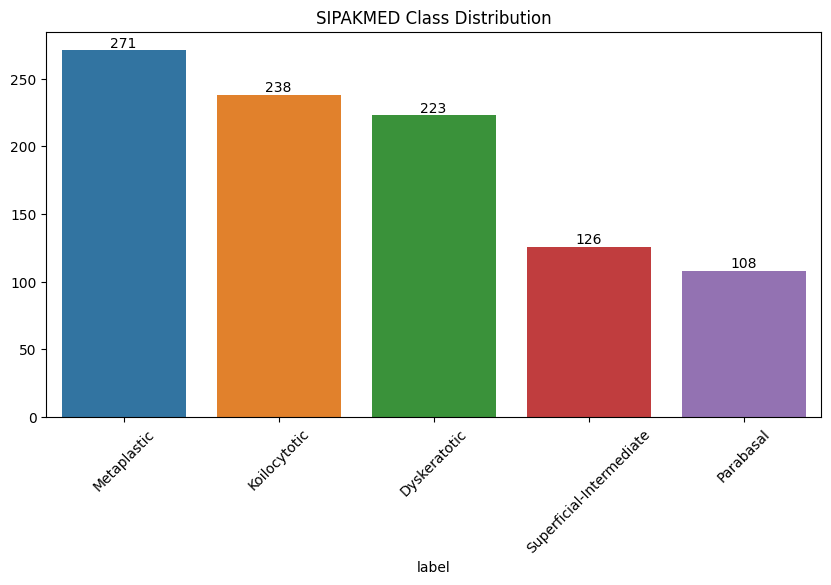

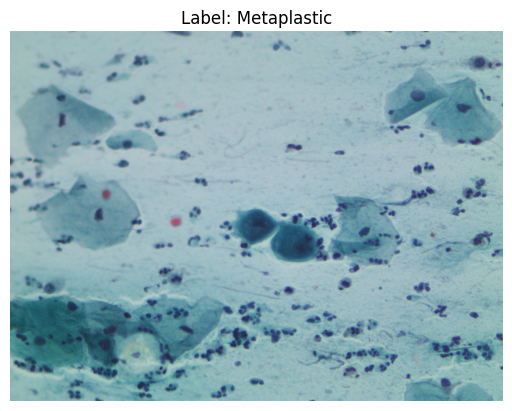

In [6]:
root_dir = "/kaggle/input/cervical-cancer-largest-dataset-sipakmed"

file_paths = []
labels = []

for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file.lower().endswith(('.bmp', '.jpg', '.png')):
            full_path = os.path.join(root, file)
            
    
            folder_name = os.path.basename(root)
            
            label = folder_name.replace('im_', '')
            
            valid_classes = ['Dyskeratotic', 'Koilocytotic', 'Metaplastic', 'Parabasal', 'Superficial-Intermediate']
            
        
            if label in valid_classes:
                file_paths.append(full_path)
                labels.append(label)


df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

print(f"Total images found: {len(df)}")
print("Unique Labels:", df['label'].unique())
class_counts = df['label'].value_counts()

print("Class Distribution:")
print(class_counts)

plt.figure(figsize=(10, 5))
ax = sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("SIPAKMED Class Distribution")
plt.xticks(rotation=45)
for i in ax.containers:
    ax.bar_label(i,)
plt.show()
try:
    random_index = random.randint(0, len(df) - 1)
    random_row = df.iloc[random_index]
    
    img = Image.open(random_row['file_path'])
    plt.imshow(img)
    plt.title(f"Label: {random_row['label']}")
    plt.axis('off')
    plt.show()
except Exception as e:
    print(f"Error displaying image: {e}")

In [7]:
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df['label'], random_state=seed)
valid_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['label'], random_state=seed)

print(f"Train size: {len(train_df)}")
print(f"Valid size: {len(valid_df)}")
print(f"Test size:  {len(test_df)}")


Train size: 676
Valid size: 145
Test size:  145


In [8]:
class CervicalDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        # Map class names to integers (0 to 4)
        self.label_map = {
            'Dyskeratotic': 0, 
            'Koilocytotic': 1, 
            'Metaplastic': 2, 
            'Parabasal': 3, 
            'Superficial-Intermediate': 4
        }

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        img_path = row['file_path']
        label_str = row['label']
        
        # Load Image (Convert to RGB to handle BMPs or Grayscale correctly)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        label = self.label_map[label_str]
        
        return image, label

In [9]:
train_batch = 32
val_batch = 32

# Standardize size to 224x224 (common for CNNs)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(), # Augmentation
        transforms.RandomRotation(10),     # Augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Standard ImageNet mean/std
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create Datasets
train_dataset = CervicalDataset(train_df, transform=data_transforms['train'])
valid_dataset = CervicalDataset(valid_df, transform=data_transforms['val'])
test_dataset  = CervicalDataset(test_df, transform=data_transforms['val'])

# Create Loaders
train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=val_batch, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=val_batch, shuffle=False, num_workers=2)


In [10]:
class SipakmedCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SipakmedCNN, self).__init__()
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Convolutional Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Convolutional Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Fully Connected Layers
        # Input image 224x224 -> pool -> 112 -> pool -> 56 -> pool -> 28
        # Final feature map size: 128 channels * 28 * 28
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x)))) # 224 -> 112
        x = self.pool(F.relu(self.bn2(self.conv2(x)))) # 112 -> 56
        x = self.pool(F.relu(self.bn3(self.conv3(x)))) # 56 -> 28
        
        x = x.view(x.size(0), -1) # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

num_classes = 5 # SIPAKMED has 5 classes
model = SipakmedCNN(num_classes=num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

summary(model, input_size=(train_batch, 3, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
SipakmedCNN                              [32, 5]                   --
├─Conv2d: 1-1                            [32, 32, 224, 224]        896
├─BatchNorm2d: 1-2                       [32, 32, 224, 224]        64
├─MaxPool2d: 1-3                         [32, 32, 112, 112]        --
├─Conv2d: 1-4                            [32, 64, 112, 112]        18,496
├─BatchNorm2d: 1-5                       [32, 64, 112, 112]        128
├─MaxPool2d: 1-6                         [32, 64, 56, 56]          --
├─Conv2d: 1-7                            [32, 128, 56, 56]         73,856
├─BatchNorm2d: 1-8                       [32, 128, 56, 56]         256
├─MaxPool2d: 1-9                         [32, 128, 28, 28]         --
├─Linear: 1-10                           [32, 512]                 51,380,736
├─Dropout: 1-11                          [32, 512]                 --
├─Linear: 1-12                           [32, 5]                  

# **Training**

In [11]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=20, patience=5):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    consecutive_no_improvement = 0
    
    print("Starting Training...")
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        loop = tqdm(train_loader, leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        epoch_val_loss = val_loss / total_val
        epoch_val_acc = correct_val / total_val
        
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        
        print(f"Epoch {epoch+1}: Train Loss={epoch_train_loss:.4f}, Train Acc={epoch_train_acc:.4f}, Val Loss={epoch_val_loss:.4f}, Val Acc={epoch_val_acc:.4f}")
        
        # Early Stopping & Checkpoint
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), 'best_sipakmed_model.pth')
            print("  >>> Best model saved!")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1
            
        if consecutive_no_improvement >= patience:
            print("Early stopping triggered.")
            break
            
    return history


history = train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=20)

Starting Training...


Epoch 1: Train Loss=2.9282, Train Acc=0.4053, Val Loss=1.2729, Val Acc=0.4414
  >>> Best model saved!


Epoch 2: Train Loss=1.4311, Train Acc=0.5059, Val Loss=1.0319, Val Acc=0.6483
  >>> Best model saved!


Epoch 3: Train Loss=0.9674, Train Acc=0.6272, Val Loss=0.8667, Val Acc=0.6966
  >>> Best model saved!


Epoch 4: Train Loss=0.8820, Train Acc=0.6391, Val Loss=0.7806, Val Acc=0.7310
  >>> Best model saved!


Epoch 5: Train Loss=0.8239, Train Acc=0.6731, Val Loss=0.7556, Val Acc=0.7241


Epoch 6: Train Loss=0.7306, Train Acc=0.7189, Val Loss=0.7069, Val Acc=0.7379
  >>> Best model saved!


Epoch 7: Train Loss=0.7440, Train Acc=0.6908, Val Loss=0.6845, Val Acc=0.7655
  >>> Best model saved!


Epoch 8: Train Loss=0.6768, Train Acc=0.7396, Val Loss=0.6427, Val Acc=0.7517


Epoch 9: Train Loss=0.6624, Train Acc=0.7544, Val Loss=0.6309, Val Acc=0.7724
  >>> Best model saved!


Epoch 10: Train Loss=0.6639, Train Acc=0.7456, Val Loss=0.6243, Val Acc=0.7862
  >>> Best model saved!


Epoch 11: Train Loss=0.6679, Train Acc=0.7382, Val Loss=0.6102, Val Acc=0.7724


Epoch 12: Train Loss=0.6151, Train Acc=0.7737, Val Loss=0.7059, Val Acc=0.7379


Epoch 13: Train Loss=0.6047, Train Acc=0.7825, Val Loss=0.5883, Val Acc=0.8069
  >>> Best model saved!


Epoch 14: Train Loss=0.5271, Train Acc=0.7959, Val Loss=0.6199, Val Acc=0.8000


Epoch 15: Train Loss=0.5314, Train Acc=0.8003, Val Loss=0.5961, Val Acc=0.8276
  >>> Best model saved!


Epoch 16: Train Loss=0.5756, Train Acc=0.7678, Val Loss=0.6186, Val Acc=0.7862


Epoch 17: Train Loss=0.5169, Train Acc=0.7959, Val Loss=0.5647, Val Acc=0.8069


Epoch 18: Train Loss=0.6142, Train Acc=0.7544, Val Loss=0.6283, Val Acc=0.7517


Epoch 19: Train Loss=0.5484, Train Acc=0.7825, Val Loss=0.6432, Val Acc=0.8138


Epoch 20: Train Loss=0.4920, Train Acc=0.8210, Val Loss=0.5807, Val Acc=0.8069
Early stopping triggered.


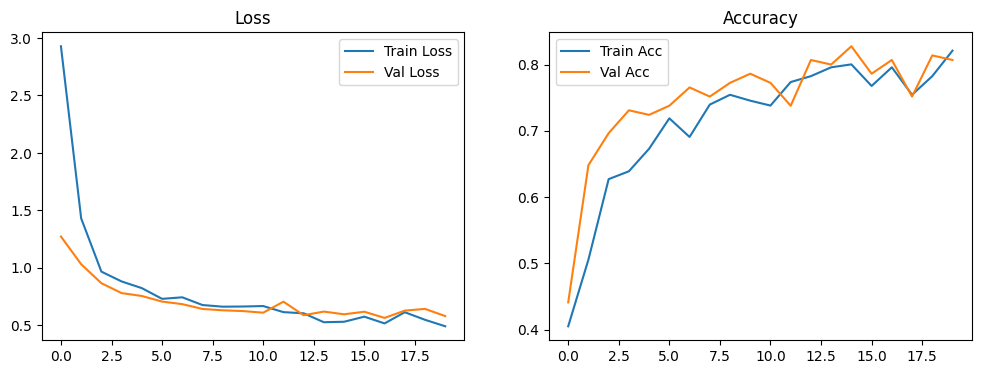

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.show()


In [13]:
model.load_state_dict(torch.load('best_sipakmed_model.pth'))
model.eval()

y_true = []
y_pred = []

print("Evaluating on Test Set...")
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

class_names = list(train_dataset.label_map.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Evaluating on Test Set...

Classification Report:
                          precision    recall  f1-score   support

            Dyskeratotic       0.87      0.79      0.83        34
            Koilocytotic       0.78      0.78      0.78        36
             Metaplastic       0.81      0.85      0.83        40
               Parabasal       0.81      0.81      0.81        16
Superficial-Intermediate       0.65      0.68      0.67        19

                accuracy                           0.79       145
               macro avg       0.78      0.78      0.78       145
            weighted avg       0.80      0.79      0.79       145



# **Evaluation**

In [14]:
import time
import torch

def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [15]:
if 'test_loader' in globals():
    loader_to_use = test_loader
elif 'dataloader_test_dataset' in globals():
    loader_to_use = dataloader_test_dataset
else:
    raise ValueError("Test loader not found! Please run the data loading cell.")

start_time = time.time()


test_loss, test_accuracy = evaluate_model(model, criterion, loader_to_use)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.793
Test Time: 2.38 seconds ---> 0.04 minutes


In [16]:
import numpy as np
from sklearn.metrics import classification_report

def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_acc = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0 for i in range(num_classes)]

    return class_acc

loader_to_use = test_loader 

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in loader_to_use:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Move to CPU and convert to numpy
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Get actual class names for the report (optional but recommended)
# Assumes 'train_dataset' is defined from previous steps
if 'train_dataset' in globals():
    # Sort keys by value to ensure order matches indices 0, 1, 2...
    class_map = train_dataset.label_map
    class_names = [k for k, v in sorted(class_map.items(), key=lambda item: item[1])]
else:
    # Fallback if map isn't available
    class_names = [str(i) for i in range(num_classes)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Calculate Per-Class Accuracy
class_acc = class_accuracy(model, loader_to_use, num_classes)

print("\nPer-Class Accuracy:")
for i in range(num_classes):
    print(f"{class_names[i]}: {class_acc[i]:.3f}")


Classification Report:
                          precision    recall  f1-score   support

            Dyskeratotic       0.87      0.79      0.83        34
            Koilocytotic       0.78      0.78      0.78        36
             Metaplastic       0.81      0.85      0.83        40
               Parabasal       0.81      0.81      0.81        16
Superficial-Intermediate       0.65      0.68      0.67        19

                accuracy                           0.79       145
               macro avg       0.78      0.78      0.78       145
            weighted avg       0.80      0.79      0.79       145


Per-Class Accuracy:
Dyskeratotic: 0.794
Koilocytotic: 0.778
Metaplastic: 0.850
Parabasal: 0.812
Superficial-Intermediate: 0.684
